In [1]:
import numpy as np
from math import pow
import scipy.optimize
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 1 载入原始数据

### 获取基站个数sta_num（第一行），终端个数dev_num（第二行），数据维度（第三行）

In [2]:
handle_list=[]
with open('./Dataset_2016c/sample_case001_input.txt','r') as handle:
    for line in handle:
        handle_list.append(line.strip('\n'))
sta_num = int(handle_list[0])
dev_num = int(handle_list[1])
dimension = int(handle_list[2])

### 构建基站位置列表

In [3]:
sta_list = []
for i in range(3,3+sta_num):
    sta_list.append([float(x) for x in handle_list[i].split('\t') if x != ''])

### 构建终端TOA列表

In [4]:
toa_list = []
for i in range(3+sta_num,3+sta_num+dev_num):
    toa_list.append([float(x) for x in handle_list[i].split('\t') if x != ''])

## 2 定位基本模型

### 构建矩阵A、X、Y，并用最小二乘法求解最小值
![矩阵](Dataset_2016c/tutorial_img/matrix.png)
![δ](Dataset_2016c/tutorial_img/delta_equation.png)

In [11]:
def residual(p,mat_A,K_k,L_k):
    mat_Y = []
    count = 0
    for i in range(sta_num):
        L_i = wave_spread_speed * toa_list[k_2][i]
        if is_valid_TOA(L_i):
            K_i = x_i*x_i+y_i*y_i+z_i*z_i
            mat_Y.append(K_i-pow(L_i*p[count+dimension],2)-K_k+pow(L_k*p[dimension],2))
            count += 1
    mat_temp = np.dot(mat_A,[p[0],p[1],p[2]])-mat_Y
    # delta = np.sum(np.multiply(mat_temp,mat_temp))
    delta = float(np.dot(mat_temp.T,mat_temp))
    return delta

def is_valid_TOA(L):
    if L <= float(200/.62):
        return True
    else:
        return False

handle_list=[]
with open('./Dataset_2016c/sample_case001_ans.txt','r') as handle:
    for line in handle:
        handle_list.append(line.strip('\n'))
ans_list = []
for line in handle_list:
    ans_list.append([float(x) for x in line.split('\t') if x != ''])

wave_spread_speed = 3e8
result_list_x = []
result_list_y = []
result_list_z = []
total_error = .0
for k_2 in range(dev_num):
    mat_A = []
    for k in range(sta_num):
        L_k = wave_spread_speed * toa_list[k_2][k]
        if is_valid_TOA(L_k):
            x_k,y_k,z_k = sta_list[k][0],sta_list[k][1],sta_list[k][2]
            K_k = x_k*x_k+y_k*y_k+z_k*z_k
            break
    if not (x_k and y_k and z_k):
        print("{:<4}:Bad signal!".format(k_2))
        continue
    for i in range(sta_num):
        L_i = wave_spread_speed * toa_list[k_2][i]
        if is_valid_TOA(L_i): # 假设每个基站的通信半径为200米，考虑到NLOS，除以折减系数（超过范围虽然有测量数据，但无效）
            x_i,y_i,z_i = sta_list[i][0],sta_list[i][1],sta_list[i][2]
            mat_A.append([x_i-x_k,y_i-y_k,z_i-z_k])
    if len(mat_A) < 4:
        print("{:<4}:-----------------Not enough valid TOA data! Available: {}-----------------".format(k_2,len(mat_A)))
        continue
    # 以TOA最小值对应的基站坐标为初始值
    p_init = sta_list[toa_list[k_2].index(min(toa_list[k_2]))][:]
    cons = ({'type': 'ineq', 'fun': lambda x: 40000-pow(x[0]-p_init[0],2)-pow(x[1]-p_init[1],2)-pow(x[2]-p_init[2],2)})
    bnds = [(None,None),(None,None),(None,None)]
    for i in range(len(mat_A)):
        p_init.append(.85) # φ_i
        bnds.append((0.62,0.98))
    param=scipy.optimize.minimize(residual,p_init,args=(mat_A,K_k,L_k),method='SLSQP',constraints=cons,bounds=bnds)
    param_round = np.round(param.x,2)
    print("{:<4}:[{:>7},{:>7},{:>7}]; Answer:[{:>7},{:>7},{:>7}]; Error: {}".format(k_2,param_round[0],param_round[1],param_round[2],ans_list[k_2][0],ans_list[k_2][1],ans_list[k_2][2],round(np.linalg.norm(param_round[:3]-ans_list[k_2]),2)))
    result_list_x.append(np.round(param.x,2)[0])
    result_list_y.append(np.round(param.x,2)[1])
    result_list_z.append(np.round(param.x,2)[2])
    total_error += np.linalg.norm(param_round[:3]-ans_list[k_2])
print("Total error: {}".format(total_error))

0   :[  -57.4,  -9.29,   4.52]; Answer:[ -21.19,   4.48,   1.48]; Error: 38.86
1   :[  -57.4,  -9.29,   4.52]; Answer:[ -81.14,  58.24,   1.38]; Error: 71.65
2   :[  -84.5,-184.89,   4.58]; Answer:[ -96.13,-215.22,   1.02]; Error: 32.68
3   :[-273.67, -21.14,   4.98]; Answer:[-296.06, -20.15,   1.59]; Error: 22.67
4   :[  36.29, -85.79,   3.19]; Answer:[  86.29,-111.06,   1.66]; Error: 56.04
5   :[  20.77, 244.49,   4.81]; Answer:[ -31.26, 244.68,    1.3]; Error: 52.15
6   :[-273.67, -21.14,   4.98]; Answer:[-286.47, -38.75,   1.73]; Error: 22.01
7   :[ 279.66,-128.13,   3.98]; Answer:[  319.3,-170.11,   1.03]; Error: 57.81
8   :[  20.77, 244.49,   4.81]; Answer:[  -37.4, 273.59,   1.73]; Error: 65.12
9   :[ 265.96, 107.13,   3.37]; Answer:[ 255.34,  66.63,   1.21]; Error: 41.92
10  :[  20.77, 244.49,   4.81]; Answer:[ 104.46, 203.54,   1.95]; Error: 93.22
11  :[  -57.4,  -9.29,   4.52]; Answer:[-120.39,  92.32,   1.72]; Error: 119.58
12  :[  20.77, 244.49,   4.81]; Answer:[ 114.52, 19

129 :[  87.23,  -13.2,   3.86]; Answer:[  48.78,   4.96,   1.49]; Error: 42.59
130 :-----------------Not enough valid TOA data! Available: 2-----------------
131 :[  -57.4,  -9.29,   4.52]; Answer:[-111.85, -40.01,   1.46]; Error: 62.59
132 :[-268.62,-100.39,   4.84]; Answer:[-316.63, -68.15,    1.8]; Error: 57.91
133 :[ 252.85, 260.85,   3.29]; Answer:[ 195.48,  321.3,    1.7]; Error: 83.35
134 :[-200.11, -24.32,   5.32]; Answer:[-136.49,   9.58,   1.02]; Error: 72.22
135 :[-268.62,-100.39,   4.84]; Answer:[-314.56,-223.65,   1.83]; Error: 131.58
136 :[-317.88, 114.67,   5.07]; Answer:[-241.97,  83.72,   1.99]; Error: 82.03
137 :[  -3.92,-273.36,   5.47]; Answer:[  11.43,-276.89,    1.7]; Error: 16.2
138 :[-317.88, 114.67,   5.07]; Answer:[-304.84,  120.8,   1.07]; Error: 14.95
139 :[-194.46,-119.81,   5.41]; Answer:[-226.19,-120.04,   1.69]; Error: 31.95
140 :[  -3.92,-273.36,   5.47]; Answer:[   95.2, -309.8,   1.15]; Error: 105.69
141 :[-268.62,-100.39,   4.84]; Answer:[-267.07,-15

264 :[-273.67, -21.14,   4.98]; Answer:[ -324.0,   28.6,   1.09]; Error: 70.87
265 :[ 279.66,-128.13,   3.98]; Answer:[ 280.73, -161.7,   1.33]; Error: 33.69
266 :[-317.88, 114.67,   5.07]; Answer:[ -169.1, 123.56,   1.96]; Error: 149.08
267 :[  -5.79, 153.43,    4.2]; Answer:[ -46.55, 212.92,   1.82]; Error: 72.15
268 :[  20.77, 244.49,   4.81]; Answer:[  72.14, 199.43,   1.52]; Error: 68.41
269 :[ 265.96, 107.13,   3.37]; Answer:[ 262.18, 117.56,   1.91]; Error: 11.19
270 :[ 219.81, 176.67,   5.12]; Answer:[ 158.01, 136.51,   1.23]; Error: 73.81
271 :[  -57.4,  -9.29,   4.52]; Answer:[ -28.06,  41.02,   1.09]; Error: 58.34
272 :[  87.23,  -13.2,   3.86]; Answer:[ 120.17, -90.47,    1.4]; Error: 84.03
273 :[  -84.5,-184.89,   4.58]; Answer:[-104.84,-237.38,   1.54]; Error: 56.38
274 :[-941.19, 1715.3,  12.81]; Answer:[ 206.65,-121.44,   1.58]; Error: 2165.94
275 :[  87.23,  -13.2,   3.86]; Answer:[  70.35,  17.95,   1.24]; Error: 35.53
276 :[ 303.74, -10.07,   3.26]; Answer:[ 299.07, 

405 :[-194.46,-119.81,   5.41]; Answer:[ -199.0,-108.19,   1.78]; Error: 12.99
406 :[-185.76, -15.41,   5.11]; Answer:[ -64.92, -48.93,   1.91]; Error: 125.44
407 :[  -57.4,  -9.29,   4.52]; Answer:[ -69.76,   70.9,   1.84]; Error: 81.18
408 :[-317.88, 114.67,   5.07]; Answer:[-290.86,  60.84,   1.94]; Error: 60.31
409 :[ 265.96, 107.13,   3.37]; Answer:[ 273.32,  85.83,   1.13]; Error: 22.65
410 :[  10.02,-119.33,   5.39]; Answer:[  26.82,-172.58,   1.79]; Error: 55.95
411 :[-200.11, -24.32,   5.32]; Answer:[-227.99,  68.23,   1.98]; Error: 96.72
412 :[   9.76, -28.57,   2.24]; Answer:[ -25.11, -53.33,   1.13]; Error: 42.78
413 :[  24.85,  90.74,   2.22]; Answer:[  10.48,   56.5,   1.35]; Error: 37.14
414 :[ -33.84,-103.06,   3.04]; Answer:[ -22.93, -92.84,   1.98]; Error: 14.99
415 :[  20.77, 244.49,   4.81]; Answer:[ -54.26, 286.29,   1.22]; Error: 85.96
416 :-----------------Not enough valid TOA data! Available: 2-----------------
417 :[  24.85,  90.74,   2.22]; Answer:[  -3.26,  5

595 :[ 166.94,  -6.84,    3.4]; Answer:[ 158.13, -40.65,   1.58]; Error: 34.99
596 :[  87.23,  -13.2,   3.86]; Answer:[  94.14, -58.26,   1.61]; Error: 45.64
597 :[-268.62,-100.39,   4.84]; Answer:[-264.91,-196.11,   1.08]; Error: 95.87
598 :[   9.76, -28.57,   2.24]; Answer:[    1.9, -30.66,   1.53]; Error: 8.16
599 :[ -24.99,-267.77,   5.67]; Answer:[-117.66,-308.53,   1.37]; Error: 101.33
600 :[-268.62,-100.39,   4.84]; Answer:[ -295.0, -86.04,   1.76]; Error: 30.19
601 :[  10.02,-119.33,   5.39]; Answer:[ 106.86,-178.13,    1.7]; Error: 113.35
602 :[ 219.81, 176.67,   5.12]; Answer:[ 208.49, 203.29,   1.23]; Error: 29.19
603 :[ 303.74, -10.07,   3.26]; Answer:[ 261.05, -16.16,   1.47]; Error: 43.16
604 :[  -84.5,-184.89,   4.58]; Answer:[-102.63,-278.45,   1.47]; Error: 95.35
605 :[  273.4, 227.51,   5.09]; Answer:[ 296.93,  230.6,   1.12]; Error: 24.06
606 :[ 166.94,  -6.84,    3.4]; Answer:[ 232.19, -55.25,   1.16]; Error: 81.28
607 :[-178.93, -51.22,   2.26]; Answer:[-163.01, -6

780 :[ -33.84,-103.06,   3.04]; Answer:[ -67.79,-102.93,   1.08]; Error: 34.01
781 :[  -84.5,-184.89,   4.58]; Answer:[-155.05,-208.29,   1.66]; Error: 74.39
782 :[  -57.4,  -9.29,   4.52]; Answer:[ -77.41,  80.53,    1.6]; Error: 92.07
783 :-----------------Not enough valid TOA data! Available: 2-----------------
784 :[-200.11, -24.32,   5.32]; Answer:[-227.07,  28.37,   1.85]; Error: 59.29
785 :[  -57.4,  -9.29,   4.52]; Answer:[ -88.61,  30.78,    1.2]; Error: 50.9
786 :[ 279.66,-128.13,   3.98]; Answer:[ 239.58,-118.49,   1.72]; Error: 41.28
787 :[  -3.92,-273.36,   5.47]; Answer:[ 115.75,-231.36,   1.48]; Error: 126.89
788 :[  -3.92,-273.36,   5.47]; Answer:[ 114.17,-231.77,   1.15]; Error: 125.27
789 :[-222.06, 318.47,   2.12]; Answer:[ -153.6, 231.47,   1.16]; Error: 110.71
790 :[-180.25, 291.01,   2.57]; Answer:[-109.18, 295.17,   1.71]; Error: 71.2
791 :[-335.44, -17.86,   6.28]; Answer:[-162.45,  89.84,   1.14]; Error: 203.84
792 :[ 627.38,-192.98,   3.52]; Answer:[ 271.11, -

1006:[  -84.5,-184.89,   4.58]; Answer:[-106.64,-251.53,   1.42]; Error: 70.29
1007:[ 109.28,  324.1,   4.85]; Answer:[ 137.33, 292.65,   1.52]; Error: 42.27
1008:[ 279.66,-128.13,   3.98]; Answer:[ 245.46, -94.53,   1.94]; Error: 47.99
1009:[ 252.85, 260.85,   3.29]; Answer:[ 262.42, 275.91,   1.51]; Error: 17.93
1010:[ 219.81, 176.67,   5.12]; Answer:[ 216.49,  142.5,   1.76]; Error: 34.49
1011:-----------------Not enough valid TOA data! Available: 3-----------------
1012:[  -84.5,-184.89,   4.58]; Answer:[ -76.32,-136.43,   1.91]; Error: 49.22
1013:[  20.77, 244.49,   4.81]; Answer:[    2.9, 215.88,   1.32]; Error: 33.91
1014:[   9.76, -28.57,   2.24]; Answer:[  -22.1, -28.99,   1.79]; Error: 31.87
1015:[-178.93, -51.22,   2.26]; Answer:[-176.45, -37.35,   1.31]; Error: 14.12
1016:[  10.02,-119.33,   5.39]; Answer:[  26.81,-147.17,   1.34]; Error: 32.76
1017:[  78.37,  96.95,   3.15]; Answer:[  98.87, 150.43,   1.64]; Error: 57.29
1018:[  20.77, 244.49,   4.81]; Answer:[  31.88, 261

### 可视化

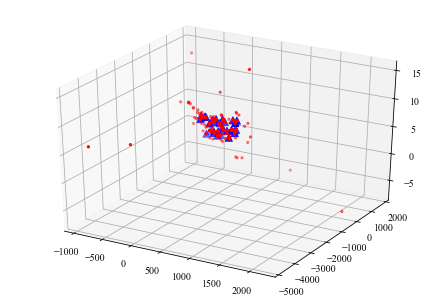

In [12]:
plt.rc('font',family='Times New Roman')
plt.rc('pdf', fonttype=42)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(result_list_x,result_list_y,result_list_z,c='r',s=5)
ax.scatter(np.array(sta_list)[:,0],np.array(sta_list)[:,1],np.array(sta_list)[:,2],c='blue',marker="^", s=50)
plt.savefig("Dataset_2016c/3d_scatter_plot.pdf")
plt.show()